### Task 2: Develop a “Tell-the-time” network.

# 1. multi-class classification problem

import packages

In [2]:
import tensorflow as tf
import keras 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Image



After loading the data, we classify the labels into 24 classes, then use one-hot encoding for transformation. 
    
We split data into 80/10/10% for training/validation and test sets respectively. 
    
The train_test_split splits the data out of order with setting the value of shuffle to be true as default. 

    

Data preprocessing

In [3]:
X_original = np.load('images.npy')
y_original = np.load('labels.npy')

## 1.1 Using 24 multi-class classification

After loading the data, we classify the labels into 24 classes, then use one-hot encoding for transformation. 
    
We split data into 80/10/10% for training/validation and test sets respectively. 
    
The train_test_split splits the data out of order with setting the value of shuffle to be true as default. 

In [3]:
y = np.zeros(y_original.shape[0])
for i, y_ in enumerate(y_original):
    y[i] = ((y_[0]%12)* 60 + y_[1])//30

# one-hot encoding
y = keras.utils.to_categorical(y, num_classes=24)
X = X_original.astype('float32') / 255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Then we start to build CNN. 

The output layer has 24 neurons, using the softmax activation function which outputs a probability distribution over 24 classes.

The model is compiled with the Adam optimizer.

The loss function is categorical crossentropy, which is ideal for multi-class classification problems.
</font>

We customize loss function to avoid penalize predictions near boundaries like 0 and 11 heavily.

In [4]:
def get_custom_loss(T):
    def custom_circular_loss(y_true, y_pred):
        y_true_class = tf.argmax(y_true, axis=1)
        y_pred_class = tf.argmax(y_pred, axis=1)

        abs_diff = tf.abs(y_true_class - y_pred_class)
        
        circular_diff = tf.minimum(abs_diff, T - abs_diff)
        
        cce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
        penalty = tf.cast(circular_diff, tf.float32) / T
        custom_loss = cce_loss + penalty  
        
        return custom_loss
    return custom_circular_loss

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), padding='SAME', strides=2, activation='relu', input_shape=(75, 75, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3), padding='SAME', strides=2, activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(24, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss=get_custom_loss(24), metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Visualize the structure of model.

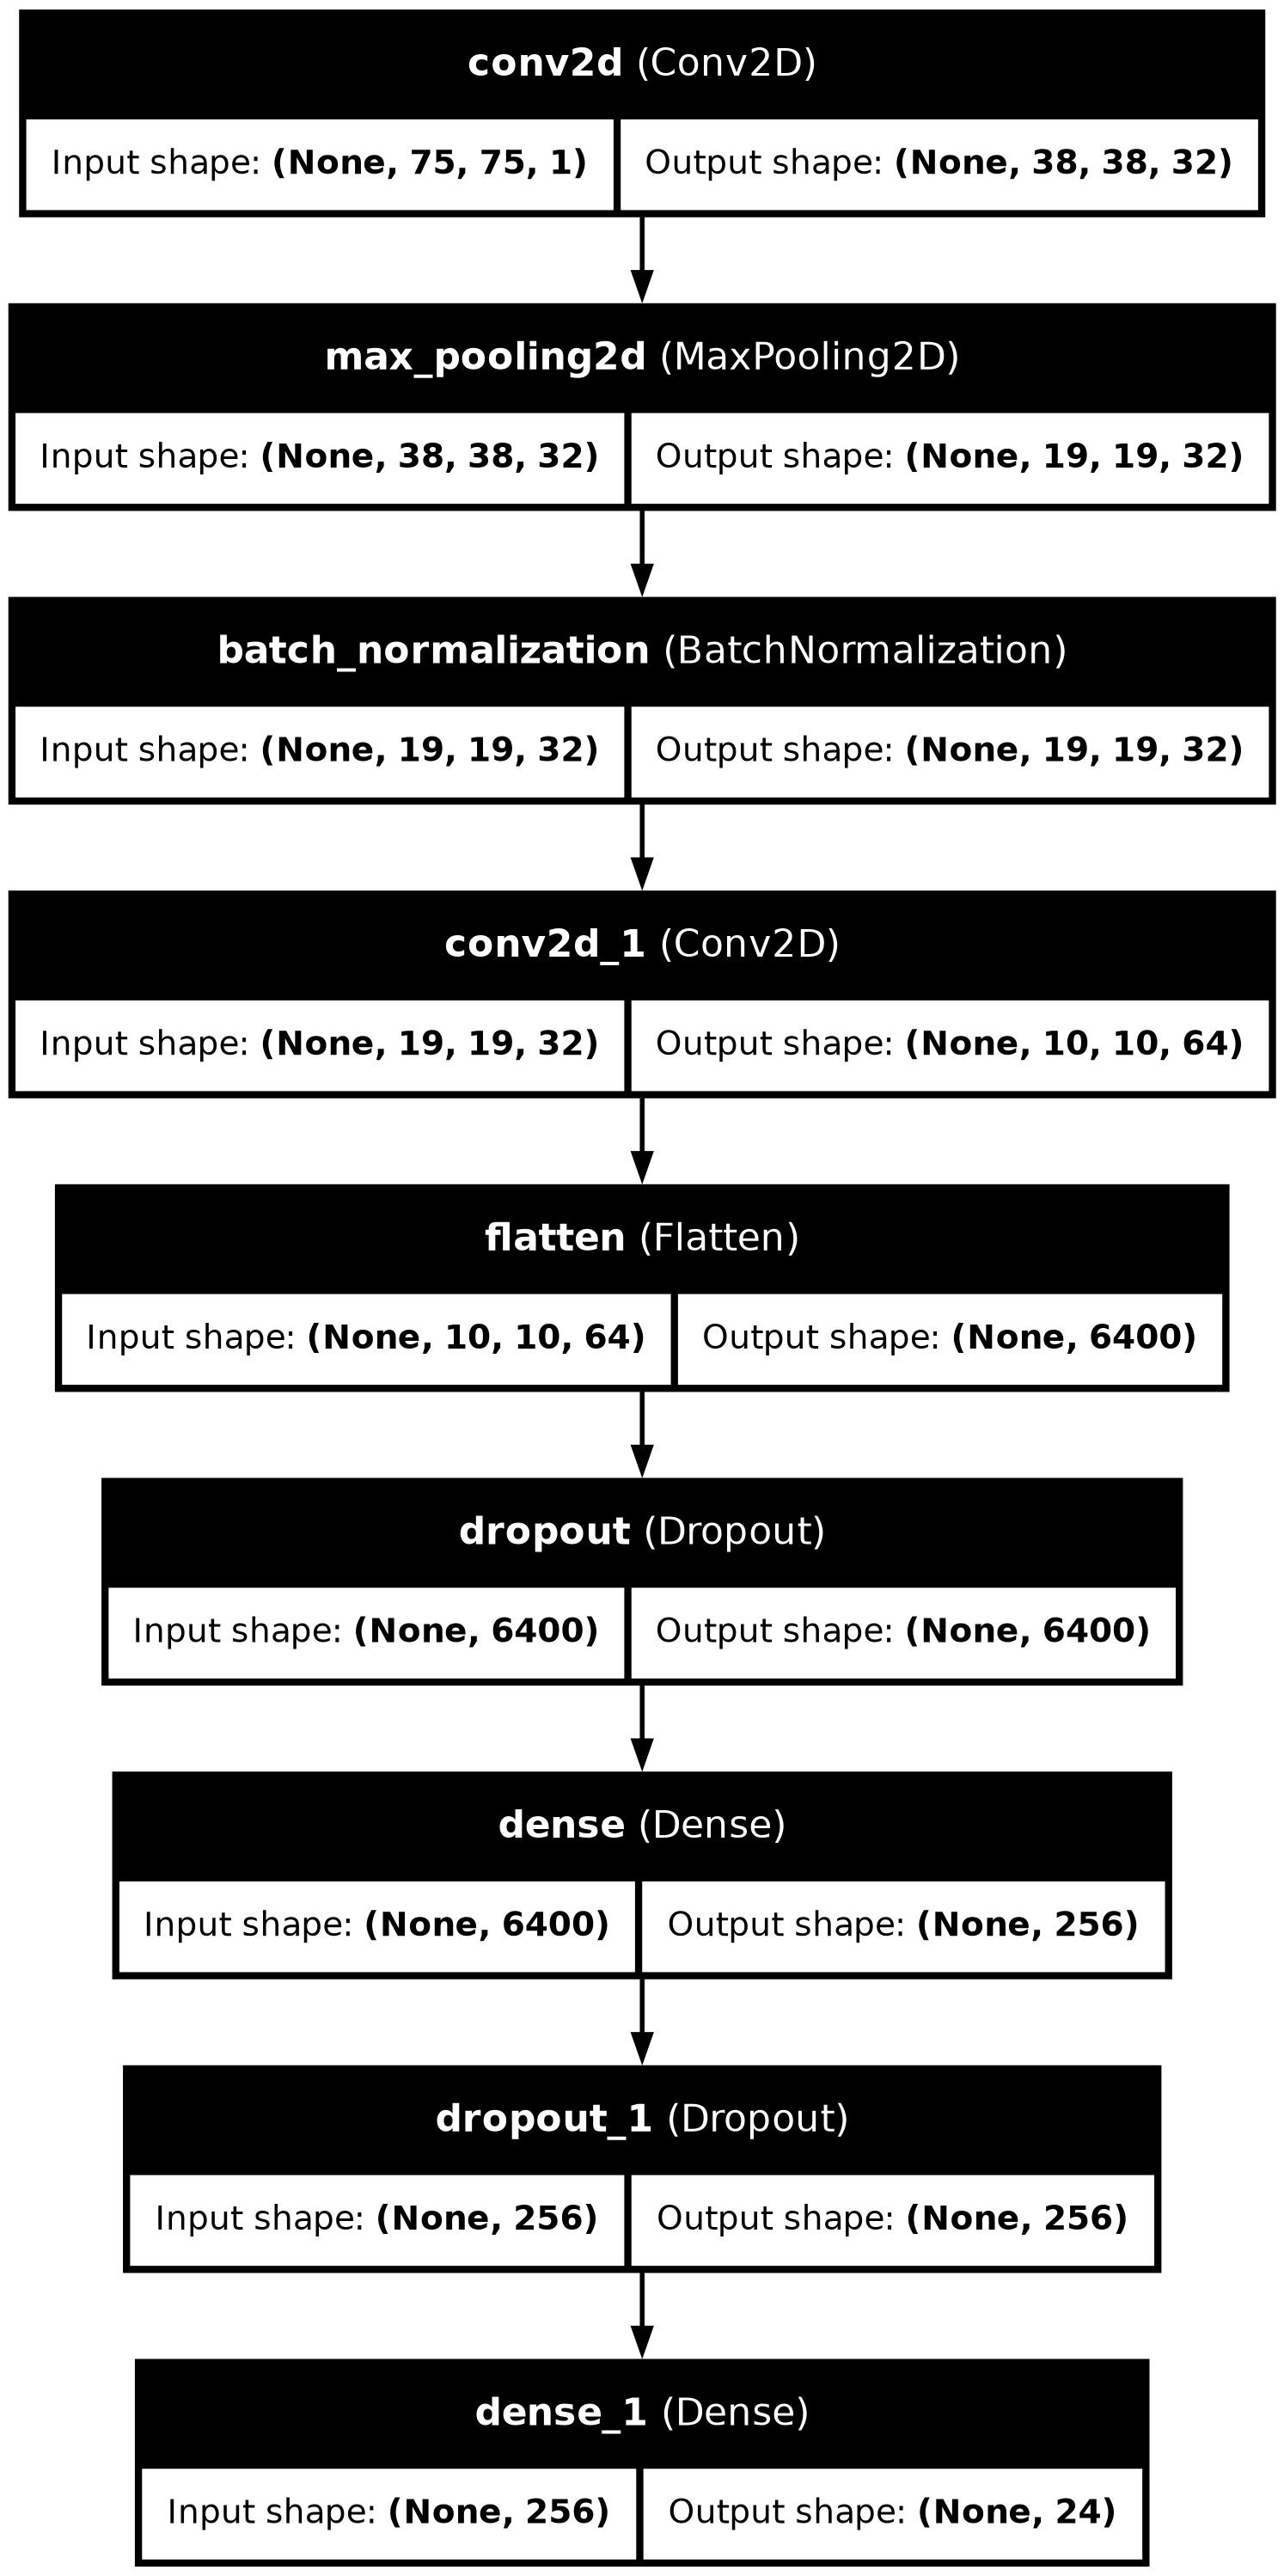

In [6]:
# keras.utils.plot_model 
keras.utils.plot_model(model, to_file='24class.png', show_shapes=True, show_layer_names=True)
Image(filename='24class.png')

In [7]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("24class_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, 
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("24class_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.0454 - loss: 3.9201 - val_accuracy: 0.0389 - val_loss: 3.7557
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0470 - loss: 3.7319 - val_accuracy: 0.0433 - val_loss: 3.6554
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.0475 - loss: 3.6341 - val_accuracy: 0.0556 - val_loss: 3.5608
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.0752 - loss: 3.5136 - val_accuracy: 0.1017 - val_loss: 3.3196
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.1060 - loss: 3.2842 - val_accuracy: 0.1622 - val_loss: 2.9988
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.1445 - loss: 3.0336 - val_accuracy: 0.2200 - val_loss: 2.7610
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.1856 - loss: 2.8235 - val_accuracy: 0.2478 - val_loss: 2.5568
Epoch 8/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.2219 - loss: 2

Let's plot to see the results.

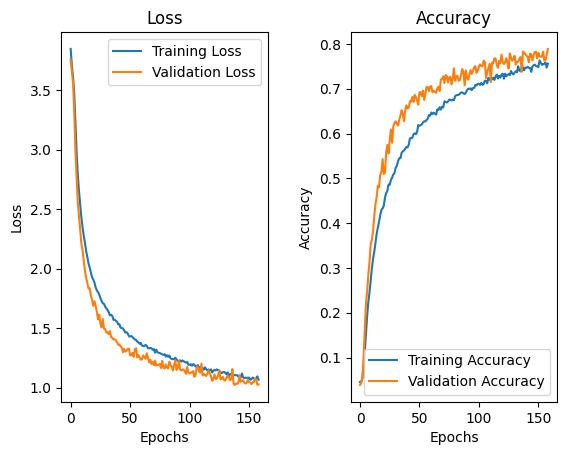

In [9]:
# model = keras.models.load_model("24class_model.keras")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplots_adjust(wspace=0.4)  


plt.show()

See the results

In [10]:
y_pred = model.predict(X_test)
print(np.argmax(y_pred, axis=1))
print(np.argmax(y_test, axis=1))
print(np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))/len(y_test))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[ 5 20 20 ...  6  0 18]
[ 5 20 20 ...  6  1 18]
0.7972222222222223


After evaluating on test set, the accuracy is 79.7%.

Encapsulate it to use the same structure.

In [6]:
def encapsulation(input_shape):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), padding='SAME', strides=2, activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, (3, 3), padding='SAME', strides=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.5))
    return model

## 1.2 Using 48 multi-class classification


Grouping all the samples into 48 categories with 15-minute interval, and then applying the CNN on them to see how it works.

In [34]:
y = np.zeros(y_original.shape[0])
for i, y_ in enumerate(y_original):
    y[i] = ((y_[0]%12)* 60 + y_[1])/15

y = keras.utils.to_categorical(y, num_classes=48)
X = X_original.astype('float32') / 255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=24)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24)

In [35]:
input_shape = (75, 75, 1)
model = encapsulation(input_shape)
model.add(keras.layers.Dense(48, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss=get_custom_loss(48), metrics=['accuracy'])

In [36]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("48class_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, 
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("48class_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.0186 - loss: 4.6037 - val_accuracy: 0.0250 - val_loss: 4.4472
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.0225 - loss: 4.4200 - val_accuracy: 0.0172 - val_loss: 4.3425
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.0210 - loss: 4.3260 - val_accuracy: 0.0233 - val_loss: 4.2842
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.0248 - loss: 4.2622 - val_accuracy: 0.0250 - val_loss: 4.2230
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.0293 - loss: 4.2002 - val_accuracy: 0.0317 - val_loss: 4.1295
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.0544 - loss: 4.0569 - val_accuracy: 0.0822 - val_loss: 3.8861
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.0896 - loss: 3.8128 - val_accuracy: 0.1472 - val_loss: 3.5240
Epoch 8/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.1301 - loss: 3

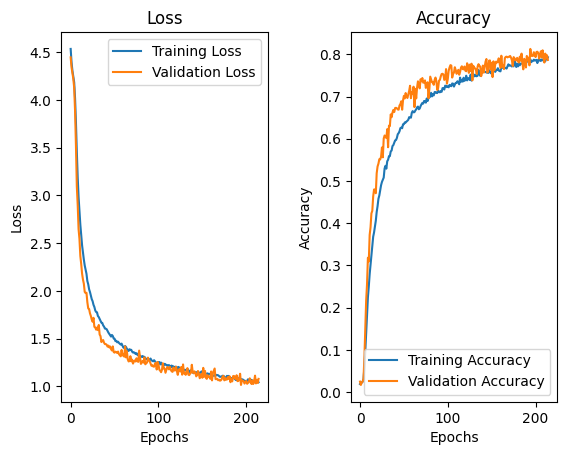

In [37]:
# model = keras.models.load_model("48class_model.keras")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplots_adjust(wspace=0.4) 

plt.show()

See the results.

In [38]:
y_pred = model.predict(X_test)
print(np.argmax(y_pred, axis=1))
print(np.argmax(y_test, axis=1))
print(np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))/len(y_test))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[32 47 22 ... 22  9 35]
[32 47 22 ... 22  9 38]
0.7955555555555556


The accuracy of prediction is 79.5%, which is not bad. Then we can try 720 classes using the same architecture to see how it performs.

## 1.3 Using 720 multi-class classification


Grouping all the samples into 720 categories, and then applying the CNN on them to see how it works.

First, customize a new loss function with 10 minutes tolerance, which means if the difference between the predict value and the actual value is less than 10 minutes, there will be no penalty to the loss function.

1. custom loss function

In [5]:
def get_custom_circular_loss_t(T, tolerance):
    def custom_circular_loss(y_true, y_pred):
        y_true_class = tf.argmax(y_true, axis=1)
        y_pred_class = tf.argmax(y_pred, axis=1)

        abs_diff = tf.abs(y_true_class - y_pred_class)
        
        circular_diff = tf.minimum(abs_diff, T - abs_diff)
        
        cce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
        penalty = tf.where(
            circular_diff <= tolerance, 
            0.0,  
            tf.cast(circular_diff, tf.float32) / T  
        )
        custom_loss = cce_loss + penalty  
        
        return custom_loss
    return custom_circular_loss

In [10]:
y = np.zeros(y_original.shape[0])
for i, y_ in enumerate(y_original):
    y[i] = ((y_[0]%12)* 60 + y_[1])

y = keras.utils.to_categorical(y, num_classes=720)
X = X_original.astype('float32') / 255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=24)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24)

In [11]:
input_shape = (75, 75, 1)
model = encapsulation(input_shape)

model.add(keras.layers.Dense(720, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss=get_custom_circular_loss_t(720, 10), metrics=['accuracy'])

In [12]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("720class_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, 
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("720class_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 8.3151e-04 - loss: 7.2714 - val_accuracy: 5.5556e-04 - val_loss: 7.0986
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.0010 - loss: 7.0728 - val_accuracy: 5.5556e-04 - val_loss: 6.9969
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0014 - loss: 6.9706 - val_accuracy: 0.0017 - val_loss: 6.9359
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0021 - loss: 6.9111 - val_accuracy: 0.0022 - val_loss: 6.9144
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.0020 - loss: 6.8687 - val_accuracy: 0.0017 - val_loss: 6.9168
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0029 - loss: 6.8379 - val_accuracy: 0.0011 - val_loss: 6.9494
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0044 - loss: 6.8102 - val_accuracy: 0.0022 - val_loss: 6.9632
Epoch 8/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.00

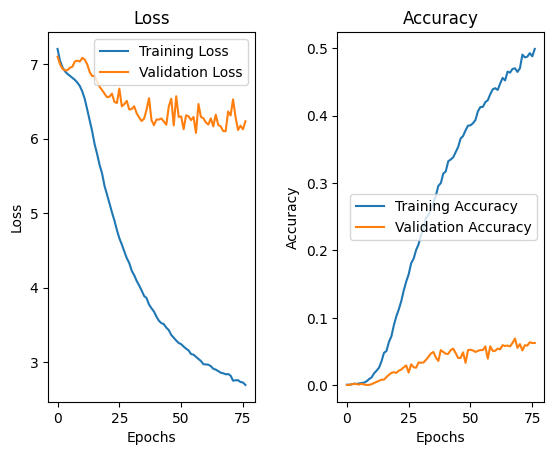

In [13]:
# model = keras.models.load_model("720class_model.keras")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplots_adjust(wspace=0.4) 

plt.show()

In [14]:
y_pred = model.predict(X_test)
print(np.argmax(y_pred, axis=1))
print(np.argmax(y_test, axis=1))
print(np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))/len(y_test))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[490 599 118 ... 336 198 529]
[486 714 343 ... 335 141 584]
0.05


The acutal correct ratio is pretty low, now calculate it again considering the tolerance.

Transform back to time form

In [6]:
def tolerance_rate(y_pred, y_test, T, tolerance):
    count = 0
    for i in range(len(y_test)):
        abs_diff = np.abs(np.argmax(y_pred[i]) - np.argmax(y_test[i]))
        min_diff = min(T - abs_diff, abs_diff)
        if min_diff <= tolerance:
            count += 1
    return count/len(y_test)

In [17]:
y_pred = model.predict(X_test)
rate = tolerance_rate(y_pred, y_test, 720, 10)
print(rate)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
0.3238888888888889


The same structure doesn't work. There is no improvement in the accuracy on validation set.

The vast number of classes means that small differences in the model’s output can lead to significant misclassifications.

Treating each minute as a distinct class ignores the relationship between adjacent minutes. As the model overfit the training data to try to learn the nuances of all 720 classes. This results in poor generalization to unseen data.


# 2. Regression problem

## 2.1.First method

In [52]:
y = np.zeros(y_original.shape[0])
for i, y_ in enumerate(y_original):
    y[i] = (y_[0]%12 + y_[1]/60)

X = X_original.astype('float32') / 255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=24)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24)

Custom “common sense” error measure

common sense error of below 10 minutes is achievable

In [7]:
def get_custom_regression_loss(T, tolerance):
    def custom_mae(y_true, y_pred):
        y_pred = abs(y_pred)
        y_pred = tf.math.floormod(y_pred, T)
        y_true = tf.math.floormod(y_true, T)
        abs_diff = tf.math.abs(y_true - y_pred)
        min_diff = tf.minimum(T - abs_diff, abs_diff)
        loss = tf.where(min_diff <= tolerance, 0.0, min_diff)

        # loss = min_diff ** 2
        custom_loss = tf.reduce_mean(loss)
        return custom_loss
    return custom_mae

In [56]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5, 5), padding='SAME', strides=2, activation='relu', input_shape=(75, 75, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(16, (5, 5), padding='SAME', strides=2, activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))

model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(1, activation='linear'))
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=get_custom_regression_loss(12, float(1/6)))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("regression_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("regression_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 3.3738 - val_loss: 3.3991
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 3.3308 - val_loss: 3.3641
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 3.3154 - val_loss: 3.3185
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 3.3053 - val_loss: 3.2976
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 3.2232 - val_loss: 3.2155
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 3.1595 - val_loss: 2.9099
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 2.9610 - val_loss: 2.7958
Epoch 8/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 2.8772 - val_loss: 2.6514
Epoch 9/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 2.7634 - val_loss: 2.6084
Epoch 10/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 2.6939 - val_loss: 2.5560
Epoch 11/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 2.6382 - val_loss: 2.4464
Epoch 12/300
450/45

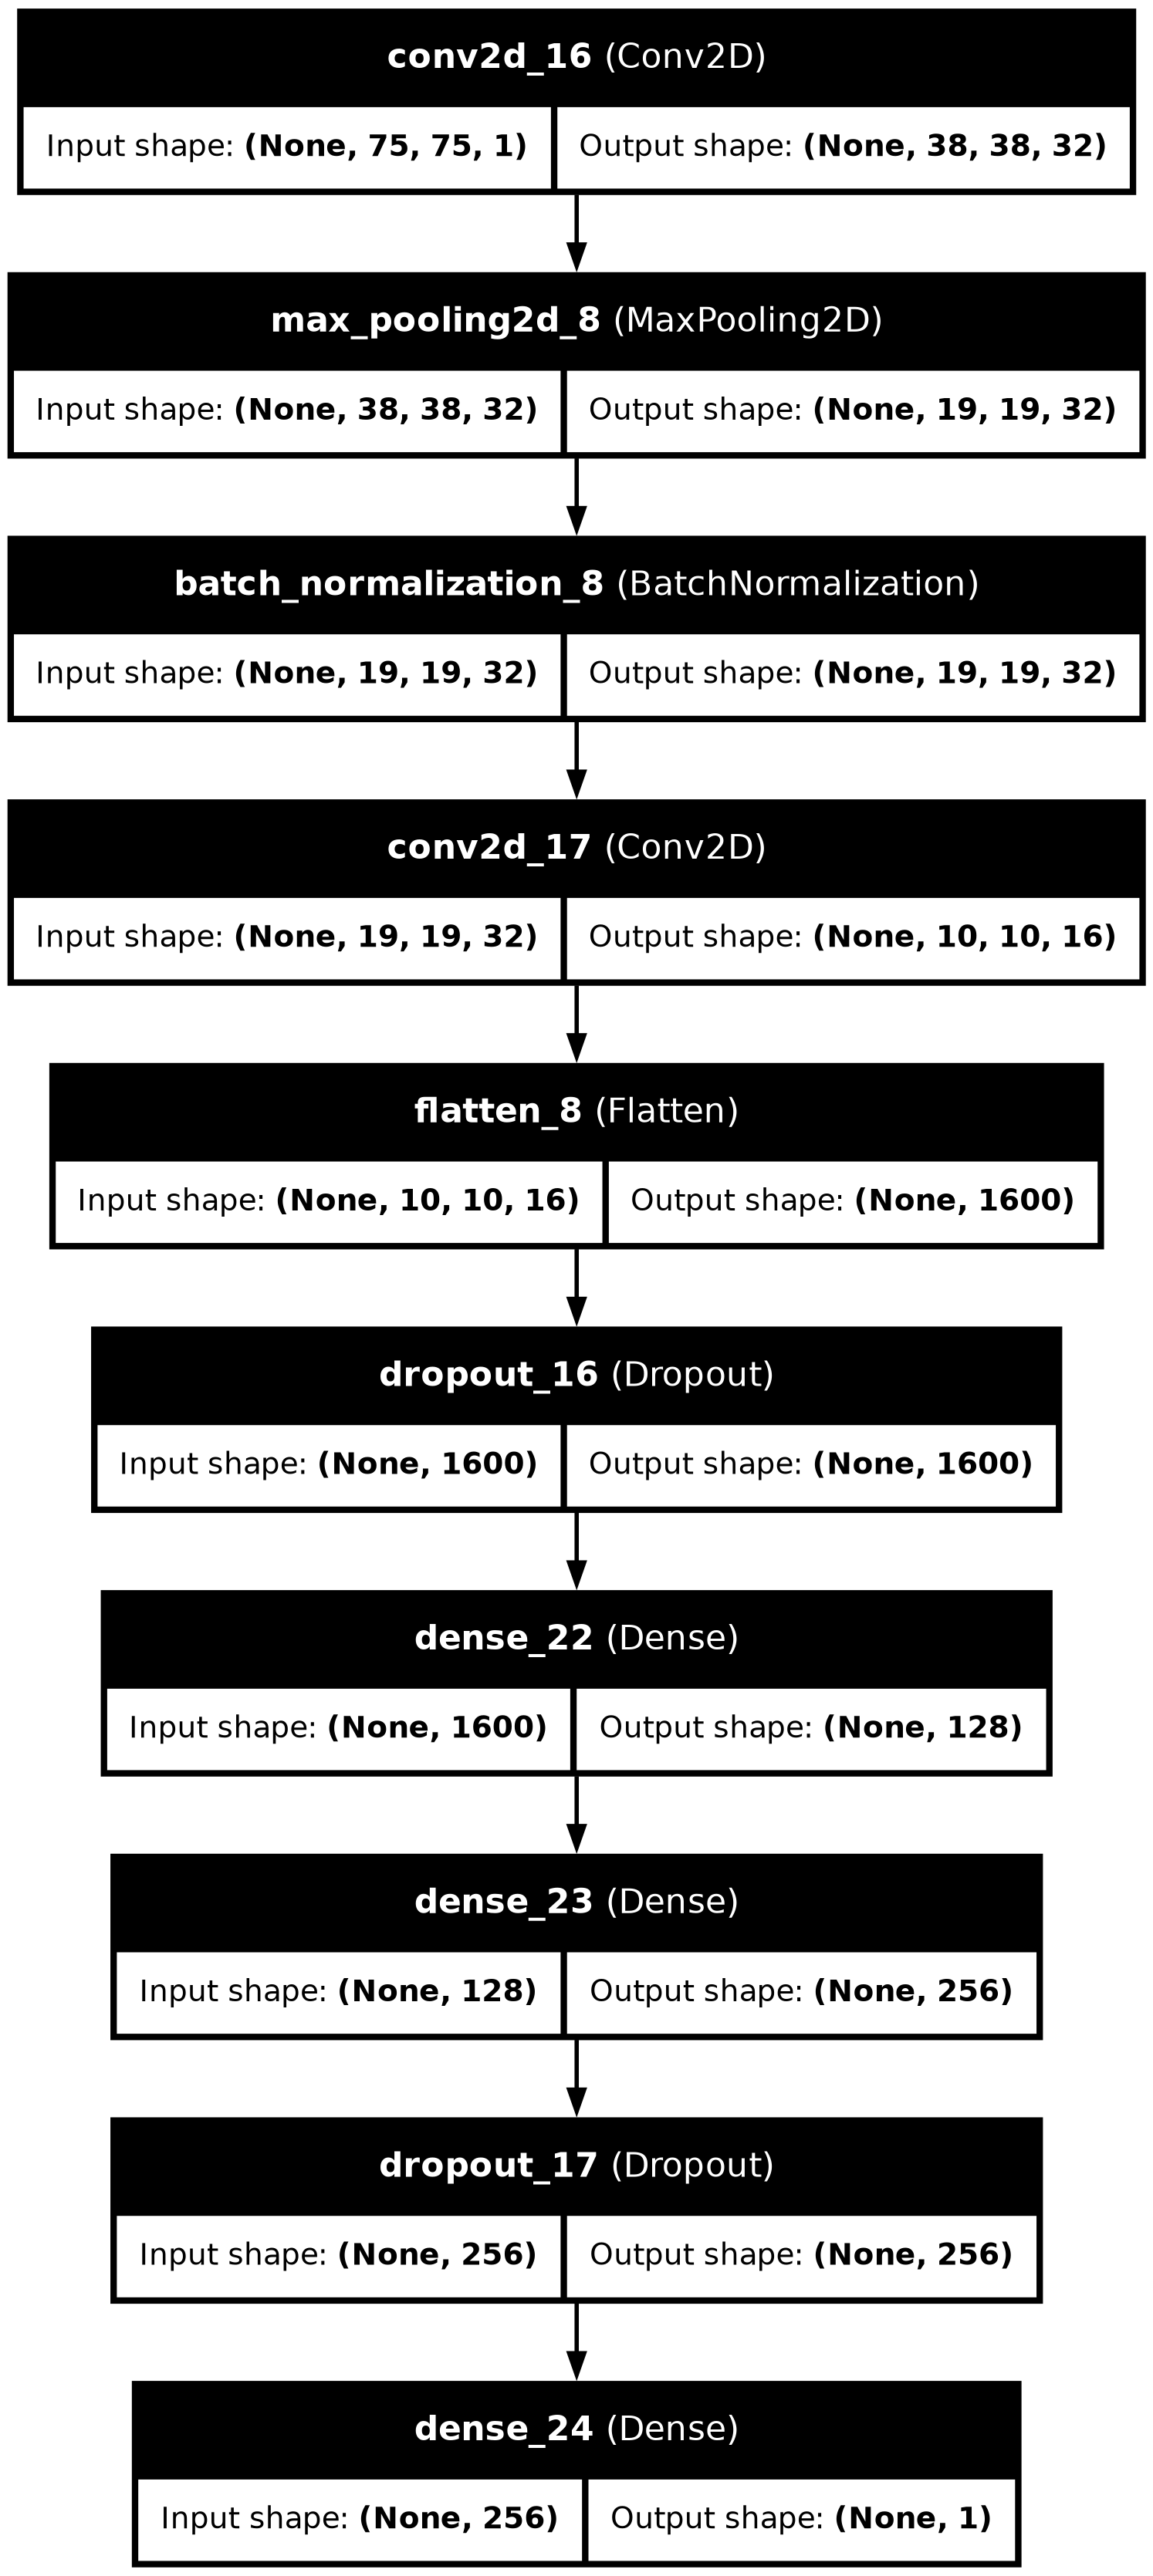

In [43]:
keras.utils.plot_model(model, to_file='regression.png', show_shapes=True, show_layer_names=True)
Image(filename='regression.png')

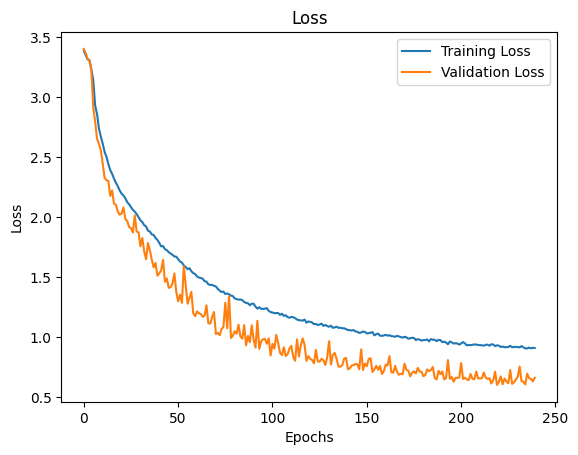

In [58]:
# model = keras.models.load_model("regression_model.keras")
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The ratio of clock that has been recognized correctly within acceptable error range.

In [8]:
def tolerance_regression_rate(y_pred, y_test, T, tolerance):
    count = 0
    y_pred = abs(y_pred)
    for i in range(len(y_test)):
        abs_diff = np.abs(y_pred[i] - y_test[i])
        min_diff = min(T - abs_diff, abs_diff)
        if min_diff <= tolerance:
            count += 1
    return count/len(y_test)

In [61]:
y_pred = model.predict(X_test)
rate = tolerance_regression_rate(y_pred, y_test, 12, float(1/6))
print(rate)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
0.3377777777777778


## 2.2 second method

total minutes

The second method is to transform labels by computing the total minutes.

In [62]:
y = np.zeros(y_original.shape[0])
for i, y_ in enumerate(y_original):
    y[i] = ((y_[0]%12)*60 + y_[1])

X = X_original.astype('float32') / 255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=24)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24)

In [63]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5, 5), padding='SAME', strides=2, activation='relu', input_shape=(75, 75, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(16, (5, 5), padding='SAME', strides=2, activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))

model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(1, activation='linear'))
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss=get_custom_regression_loss(720, 10))

In [64]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("regression_minutes_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("regression_minutes_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 180.4944 - val_loss: 181.9734
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 180.3950 - val_loss: 176.0294
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 167.4669 - val_loss: 151.9981
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 149.1508 - val_loss: 146.2106
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 144.9802 - val_loss: 139.9470
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 141.4911 - val_loss: 135.3257
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 141.1020 - val_loss: 135.4111
Epoch 8/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 138.9848 - val_loss: 127.3998
Epoch 9/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 136.5461 - val_loss: 127.1836
Epoch 10/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 133.7894 - val_loss: 132.8536
Epoch 11/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 133.1

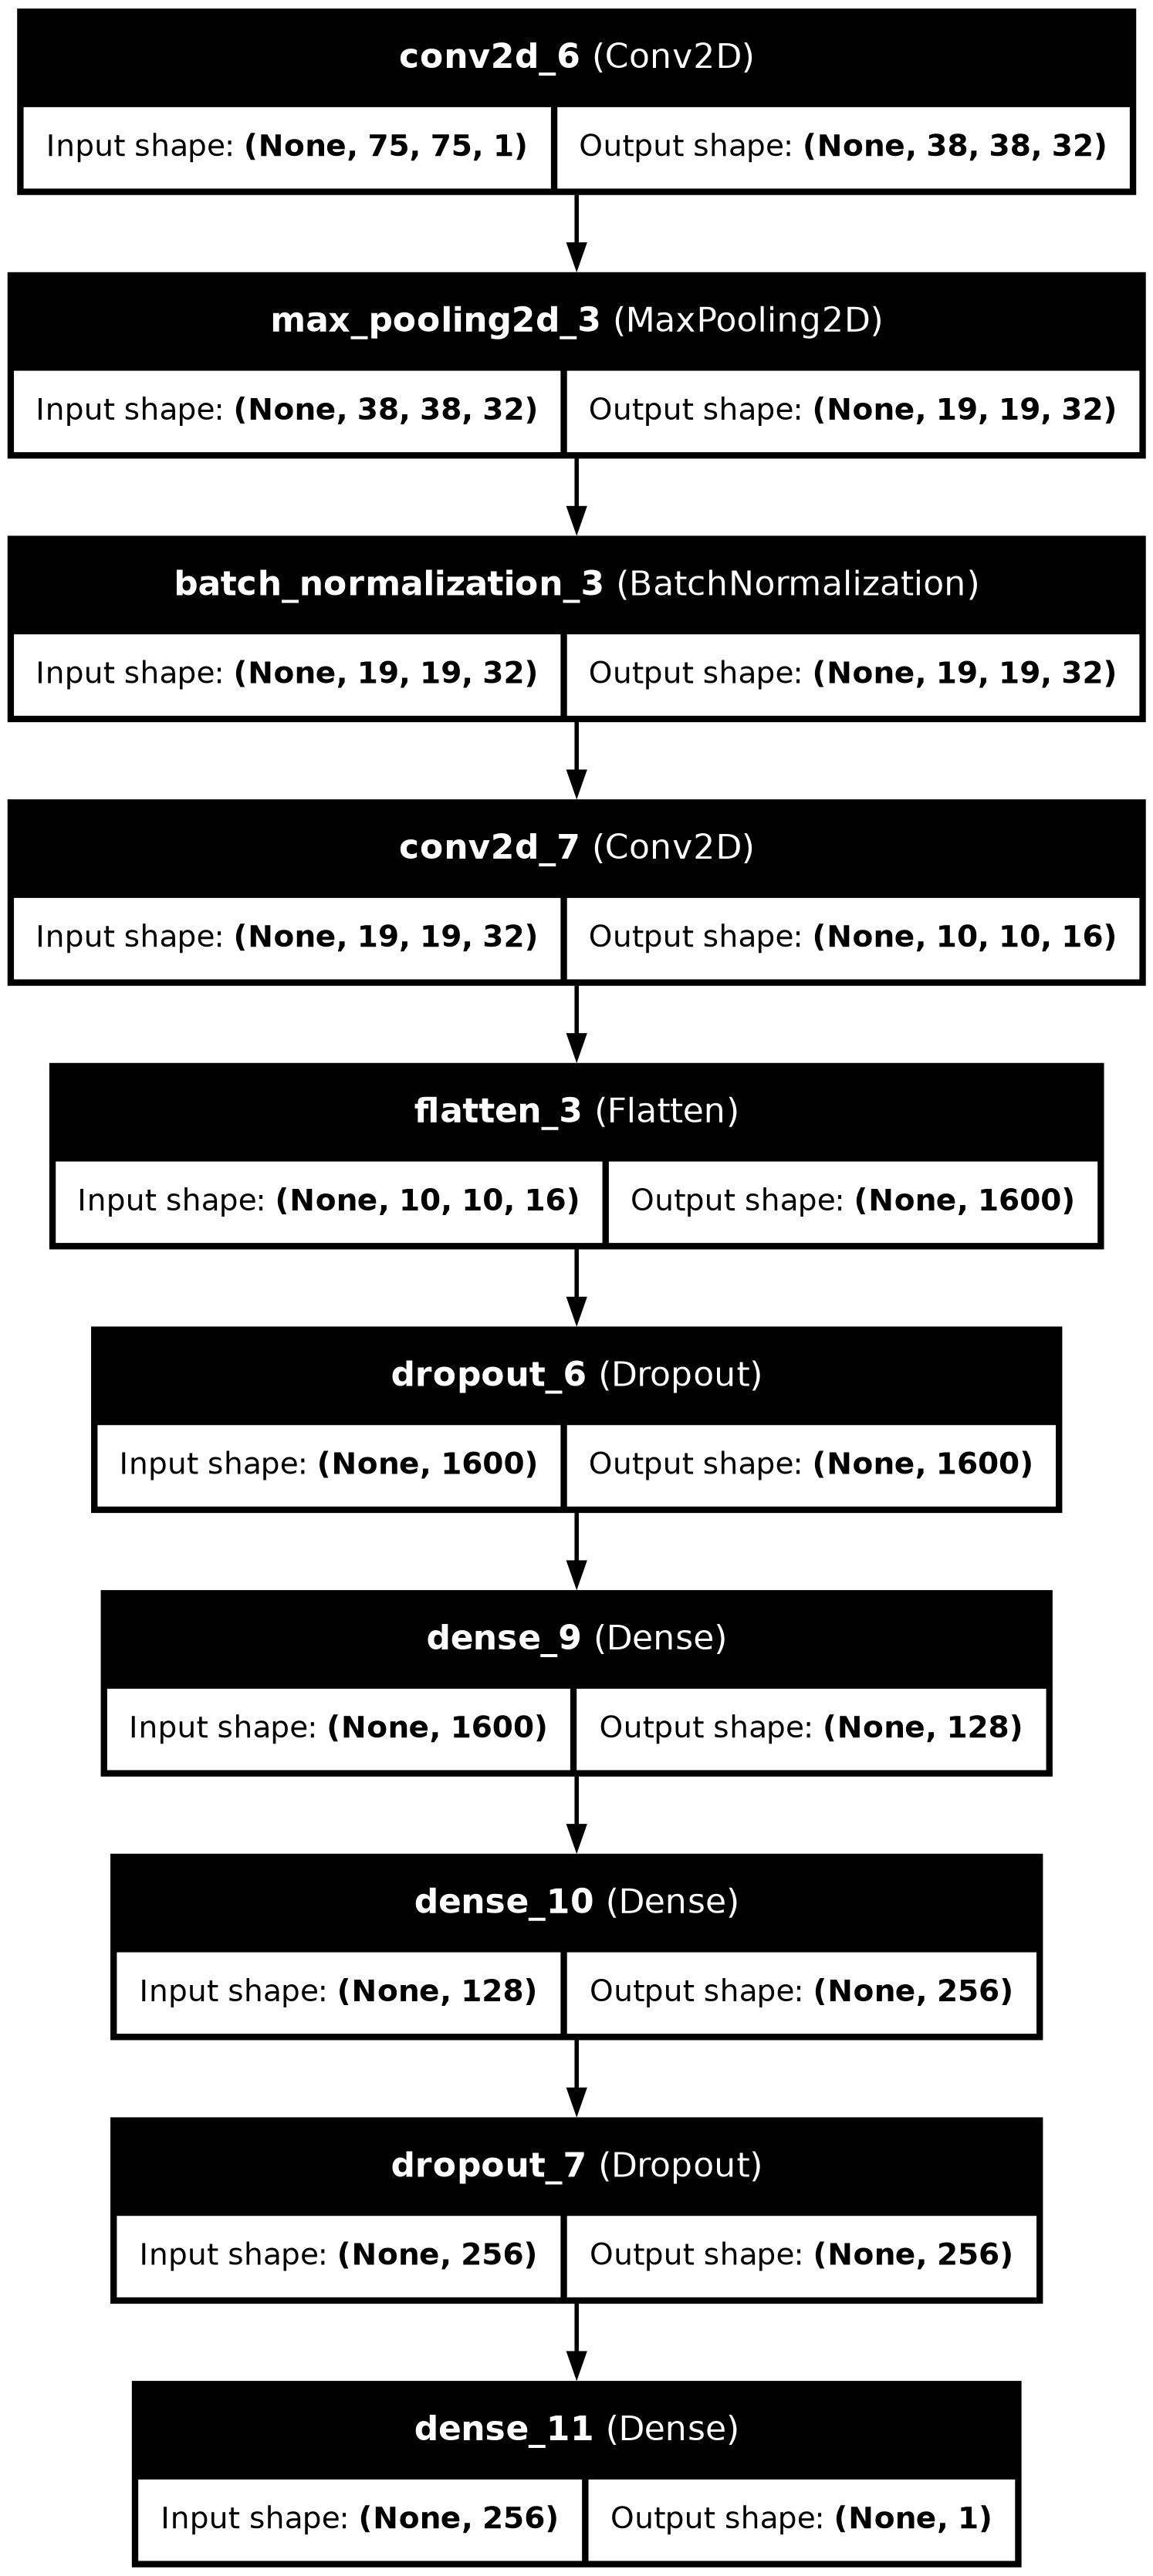

In [24]:
keras.utils.plot_model(model, to_file='regression_minutes.png', show_shapes=True, show_layer_names=True)
Image(filename='regression_minutes.png')

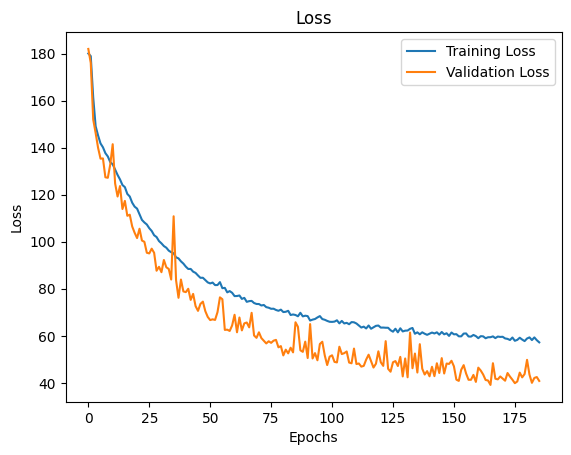

In [65]:
# model = keras.models.load_model("regression_model_minutes.keras")
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [70]:
y_pred = model.predict(X_test)
rate = tolerance_regression_rate(y_pred, y_test, 720, 10)
print(rate)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
0.2538888888888889


# 2. Multi-head problem

Cutomize common error function, which transform labels to total minutes and count inconsistency considering 10 minutes' tolerance.

In [9]:
def common_error(y_pred, y_true):
    count = 0
    for i in range(len(y_pred)):
        true_hour, true_minute = y_true[i]
        pred_hour, pred_minute = abs(y_pred[i])
        
        true_total_minutes = (true_hour % 12) * 60 + true_minute
        pred_total_minutes = (pred_hour % 12) * 60 + pred_minute
        
        abs_diff = np.abs(true_total_minutes - pred_total_minutes)
        minute_diff = min(abs_diff, 720 - abs_diff)  
        
        if minute_diff <= 10:
            count += 1
    
    return count / len(y_true)

## 2.1 regression

The hour and minute are numerical output of the two heads using linear activation function.

In [10]:
X = X_original.astype('float32') / 255.0
y = y_original

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=24)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24)

In [11]:
inputs = keras.Input(shape=(75, 75, 1), name="inputs")

conv1 = keras.layers.Conv2D(16, (3, 3), padding='SAME', strides=2, activation='relu', name="conv1")(inputs)
bn1 = keras.layers.BatchNormalization()(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(bn1)

conv2 = keras.layers.Conv2D(16, (3, 3), padding='SAME', strides=2, activation='relu', name="conv2")(pool1)
bn2 = keras.layers.BatchNormalization()(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(bn2)

flatten = keras.layers.Flatten(name="flatten")(pool2)

dense_hours = keras.layers.Dense(32, activation='relu', name="dense_hours", kernel_regularizer=keras.regularizers.l2(0.0001))(flatten)
dropout_hours = keras.layers.Dropout(0.5, name="dropout_hours")(dense_hours)
output_hours = keras.layers.Dense(1, activation='linear', name="output_hours")(dropout_hours)

conv3 = keras.layers.Conv2D(16, (3, 3), padding='SAME', activation='relu', name="conv3")(pool2)
bn3 = keras.layers.BatchNormalization()(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool3")(bn3)

conv4 = keras.layers.Conv2D(8, (3, 3), padding='SAME', activation='relu', name="conv4")(pool3)
bn4 = keras.layers.BatchNormalization()(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool4")(bn4)

flatten_minutes = keras.layers.Flatten(name="flatten_minutes")(pool4)

dense_minutes = keras.layers.Dense(16, activation='relu', name="dense_minutes", kernel_regularizer=keras.regularizers.l2(0.001))(flatten_minutes)
dropout_minutes = keras.layers.Dropout(0.5, name="dropout_minutes")(dense_minutes)
bn_dense1 = keras.layers.BatchNormalization()(dropout_minutes)

output_minutes = keras.layers.Dense(1, activation='linear', name="output_minutes")(bn_dense1)

model = keras.Model(inputs=inputs, outputs=[output_hours, output_minutes])
optimizer = keras.optimizers.Adam(learning_rate=0.003) 
model.compile(loss={"output_hours": get_custom_regression_loss(12, float(1/6)), "output_minutes": get_custom_regression_loss(720, 10)}, loss_weights={"output_hours": 0.5, "output_minutes": 0.5}, optimizer=optimizer)


In [12]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("multihead_regression_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train, [y_train[:, 0], y_train[:, 1]], epochs=300,
    validation_data=(X_valid, [y_valid[:, 0], y_valid[:, 1]]),
    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("multihead_regression_model.keras")

Epoch 1/300


I0000 00:00:1730495052.999799     139 service.cc:145] XLA service 0x79903c002bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730495052.999855     139 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 52/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.1947

I0000 00:00:1730495058.766977     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 13.1728 - val_loss: 8.7851
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3993 - val_loss: 46.3096
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.8615 - val_loss: 8.1472
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9094 - val_loss: 8.5544
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5136 - val_loss: 7.1912
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1027 - val_loss: 7.3856
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9439 - val_loss: 7.6011
Epoch 8/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8595 - val_loss: 6.7407
Epoch 9/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6630 - val_loss: 6.8680
Epoch 10/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6076 - val_loss: 6.7646
Epoch 11/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4882 - val_loss: 8.2306
Epoch 12/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

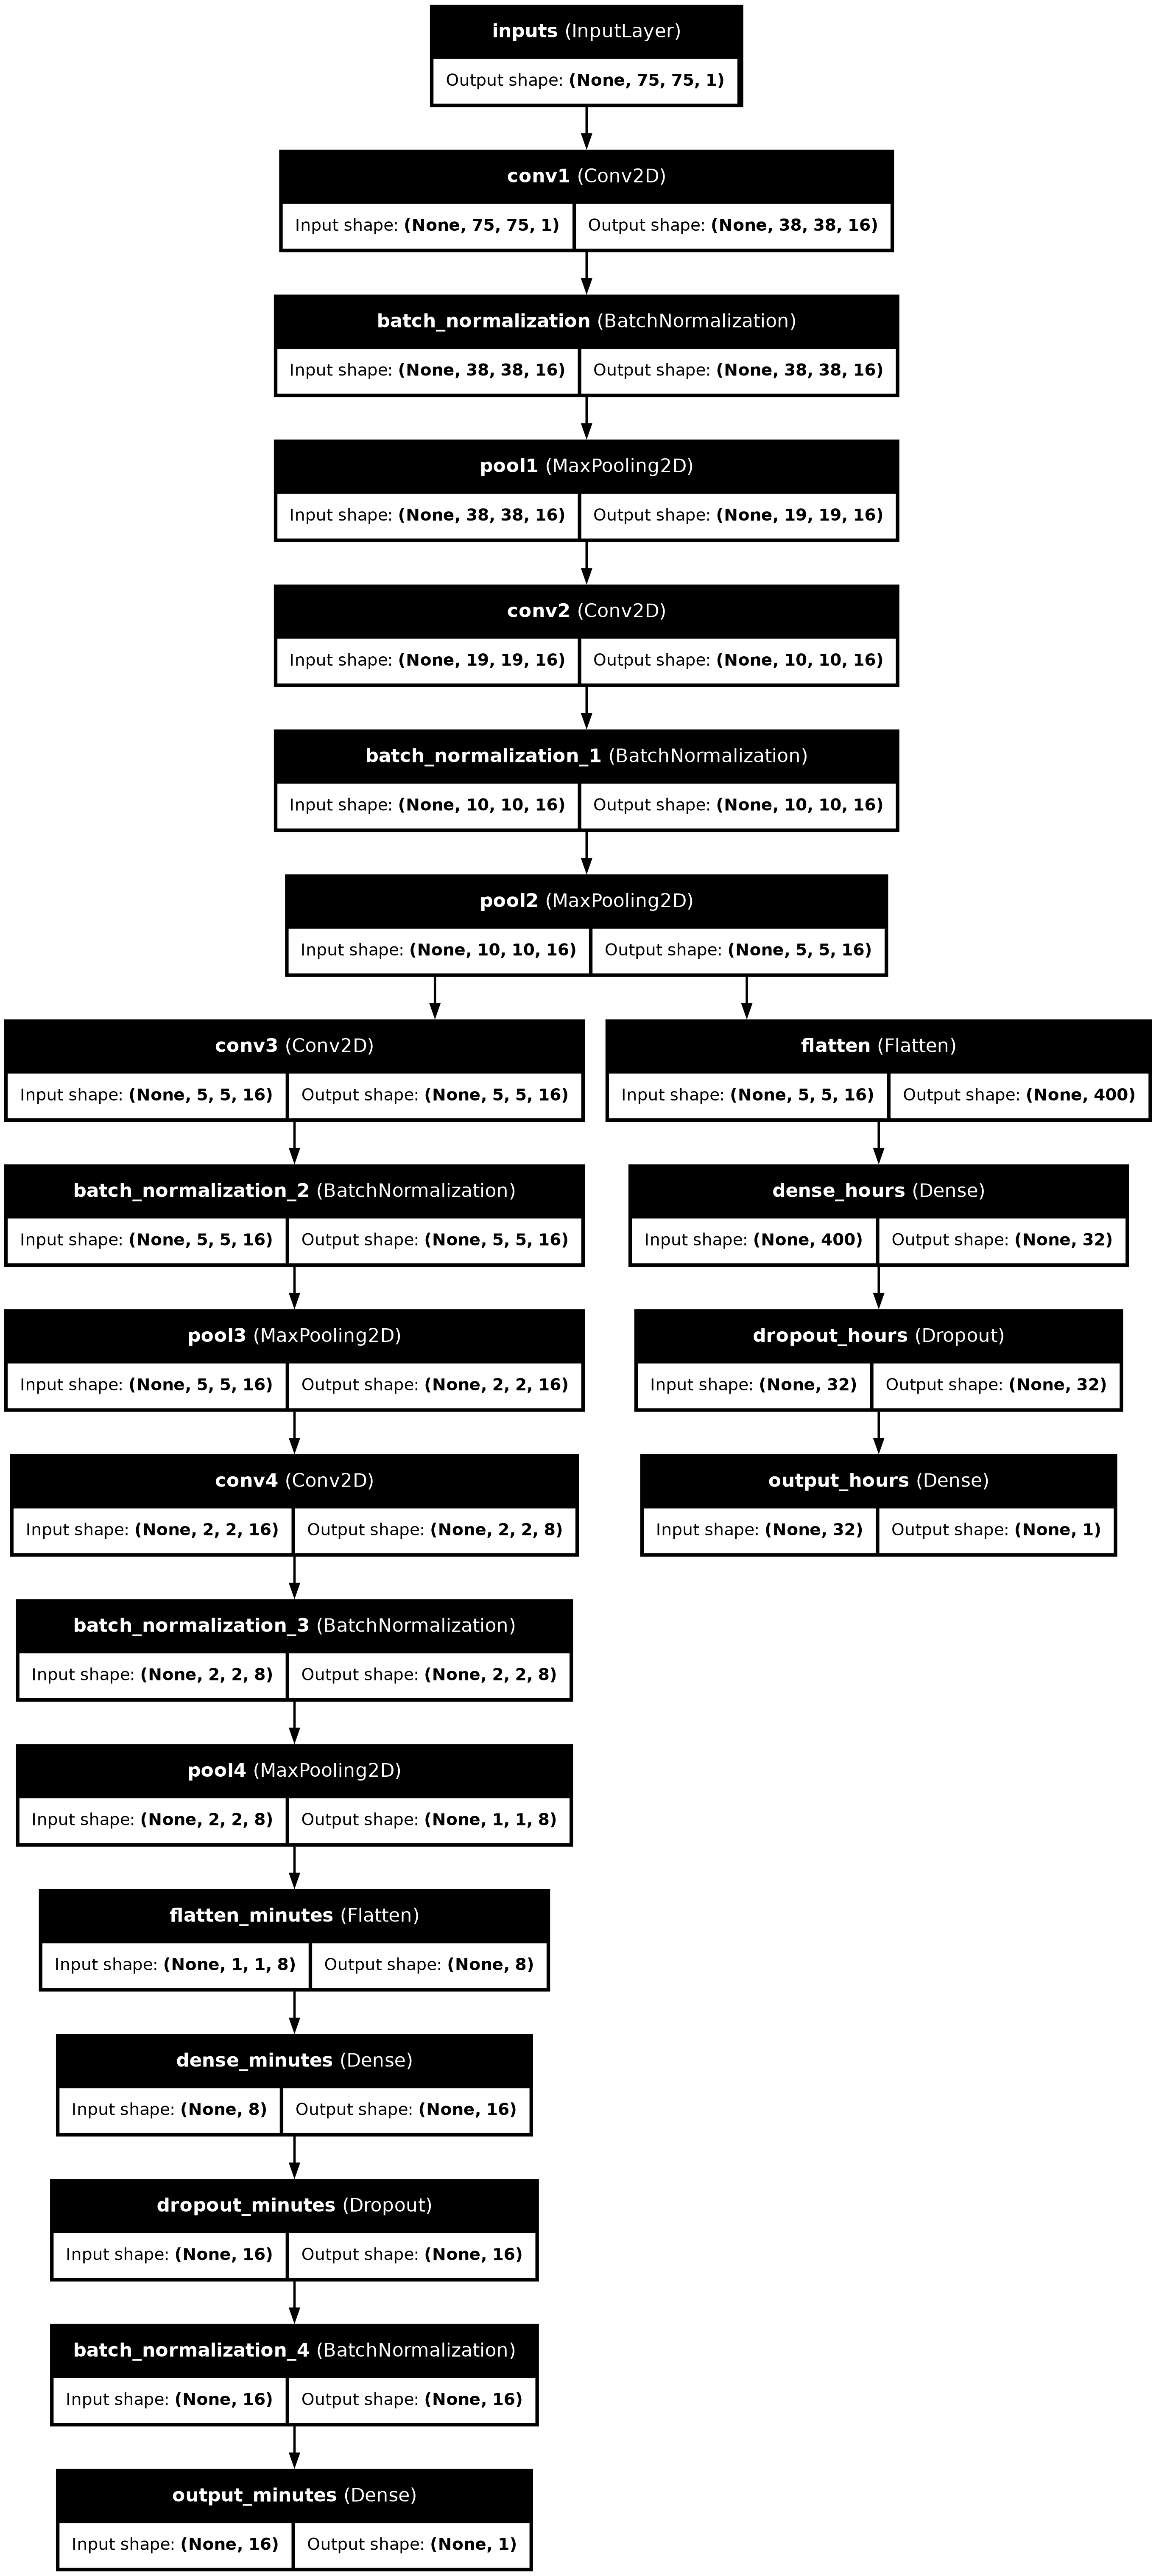

In [13]:
keras.utils.plot_model(model, to_file='regression_multihead.png', show_shapes=True, show_layer_names=True)
Image(filename='regression_multihead.png')

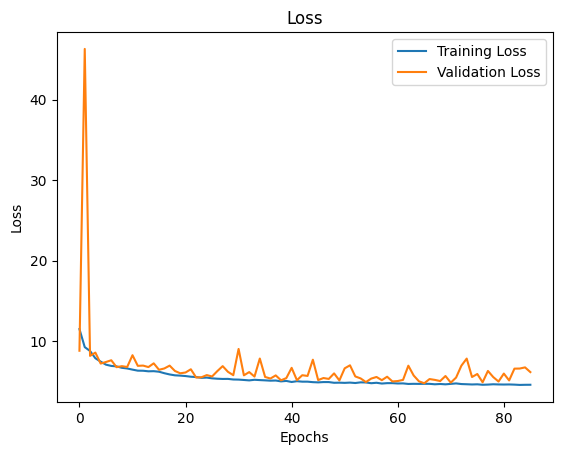

In [15]:
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
hour_pred, minute_pred = model.predict(X_test)
print(np.hstack((hour_pred, minute_pred)))
print(y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[  5.142707  -20.23246  ]
 [  9.804035   -9.645566 ]
 [  3.8531141 -36.25492  ]
 ...
 [  3.6882844 -28.918474 ]
 [  8.531663  -21.561735 ]
 [  5.9739122 -45.395683 ]]
[[ 8  6]
 [11 54]
 [ 5 43]
 ...
 [ 5 35]
 [ 2 21]
 [ 9 44]]


In [17]:
print(common_error(np.hstack((hour_pred, minute_pred)), y_test))

0.011111111111111112


## 2.2 classification 

Applying classification as the outputs, one head for predicting hours and the other head for predicting minutes.

In [11]:
X = X_original.astype('float32') / 255.0
y = y_original
y0 = y[:, 0].reshape(-1, 1)
y1 = y[:, 1].reshape(-1, 1)
hour_labels = keras.utils.to_categorical(y0, num_classes=12)
minute_labels = keras.utils.to_categorical(y1, num_classes=60)

x_train, x_temp, hour_train, hour_test, minute_train, minute_test = train_test_split(X, hour_labels, minute_labels, test_size=0.2)
x_val, x_test, hour_val, hour_test, minute_val, minute_test = train_test_split(x_temp, hour_test, minute_test, test_size=0.5)

In [12]:
inputs = keras.Input(shape=(75, 75, 1), name="inputs")

conv1 = keras.layers.Conv2D(16, (3, 3), padding='SAME', strides=2, activation='relu', name="conv1")(inputs)
bn1 = keras.layers.BatchNormalization()(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(bn1)

conv2 = keras.layers.Conv2D(16, (3, 3), padding='SAME', strides=2, activation='relu', name="conv2")(pool1)
bn2 = keras.layers.BatchNormalization()(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(bn2)

flatten = keras.layers.Flatten(name="flatten")(pool2)

dense_hours = keras.layers.Dense(128, activation='relu', name="dense_hours", kernel_regularizer=keras.regularizers.l2(0.0001))(flatten)
dropout_hours = keras.layers.Dropout(0.5, name="dropout_hours")(dense_hours)
output_hours = keras.layers.Dense(12, activation='softmax', name="output_hours")(dropout_hours)

conv3 = keras.layers.Conv2D(16, (3, 3), padding='SAME', activation='relu', name="conv3")(pool2)
bn3 = keras.layers.BatchNormalization()(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool3")(bn3)

conv4 = keras.layers.Conv2D(32, (3, 3), padding='SAME', activation='relu', name="conv4")(pool3)
bn4 = keras.layers.BatchNormalization()(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool4")(bn4)

flatten_minutes = keras.layers.Flatten(name="flatten_minutes")(pool4)

dense_minutes = keras.layers.Dense(64, activation='relu', name="dense_minutes", kernel_regularizer=keras.regularizers.l2(0.001))(flatten_minutes)
dropout_minutes = keras.layers.Dropout(0.5, name="dropout_minutes")(dense_minutes)
bn_dense1 = keras.layers.BatchNormalization()(dropout_minutes)

output_minutes = keras.layers.Dense(60, activation='softmax', name="output_minutes")(bn_dense1)

In [13]:
model = keras.Model(inputs=inputs, outputs=[output_hours, output_minutes])
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss={'output_hours':get_custom_loss(12), 'output_minutes':get_custom_circular_loss_t(60, 10)}, loss_weights={"output_hours": 0.5, "output_minutes": 0.5}, optimizer=optimizer, metrics=['accuracy', 'accuracy'])

In [14]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("multihead_classification_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(
    x_train, [hour_train, minute_train], epochs=300,
    validation_data=(x_val, [hour_val, minute_val]),
    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("multihead_classification_model.keras")


Epoch 1/300


I0000 00:00:1730498579.525388     101 service.cc:145] XLA service 0x7e077c018bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730498579.525437     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 49/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6433 - output_hours_accuracy: 0.1081 - output_minutes_accuracy: 0.0161

I0000 00:00:1730498585.920334     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 4.0760 - output_hours_accuracy: 0.0883 - output_minutes_accuracy: 0.0180 - val_loss: 3.6587 - val_output_hours_accuracy: 0.0817 - val_output_minutes_accuracy: 0.0178
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.7133 - output_hours_accuracy: 0.0853 - output_minutes_accuracy: 0.0184 - val_loss: 3.6195 - val_output_hours_accuracy: 0.0806 - val_output_minutes_accuracy: 0.0128
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.6701 - output_hours_accuracy: 0.0954 - output_minutes_accuracy: 0.0183 - val_loss: 3.6686 - val_output_hours_accuracy: 0.0800 - val_output_minutes_accuracy: 0.0194
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.6418 - output_hours_accuracy: 0.0868 - output_minutes_accuracy: 0.0207 - val_loss: 3.6019 - val_output_hours_accuracy: 0.0828 - val_output_minutes_accuracy: 0.0167
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.6221 - output_hours_accuracy: 0.0854 - o

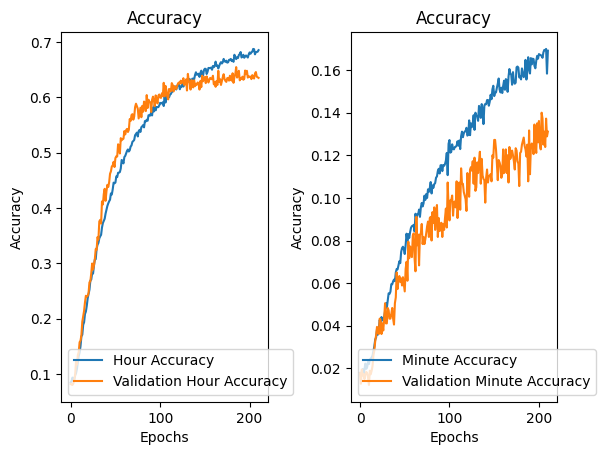

In [15]:
# model = keras.models.load_model("multihead_classification_model.keras")
plt.subplot(1, 2, 1)
plt.plot(history.history['output_hours_accuracy'], label='Hour Accuracy')
plt.plot(history.history['val_output_hours_accuracy'], label='Validation Hour Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['output_minutes_accuracy'], label='Minute Accuracy')
plt.plot(history.history['val_output_minutes_accuracy'], label='Validation Minute Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplots_adjust(wspace=0.4) 

plt.show()

In [16]:
hour_pred, minute_pred = model.predict(X_test)
print(np.argmax(minute_pred, axis=1))
print(np.argmax(minute_test, axis=1))
print(np.sum((np.argmax(minute_pred, axis=1)== np.argmax(minute_test, axis=1)))/len(minute_test))

print(np.argmax(hour_pred[2]))
print(np.argmax(hour_test[2]))
print(np.argmax(hour_test, axis=1))
print(np.sum(np.argmax(hour_pred, axis=1) == np.argmax(hour_test, axis=1))/len(hour_test))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[ 9 54 41 ... 36 21 43]
[46 12  3 ... 23 38  8]
0.020555555555555556
5
3
[2 4 3 ... 0 4 7]
0.07833333333333334


common sense error

In [17]:
y_pred = np.vstack((np.argmax(hour_pred, axis=1), np.argmax(minute_pred, axis=1))).T
y_test = np.vstack((np.argmax(hour_test, axis=1), np.argmax(minute_test, axis=1))).T
print(y_pred)
print(y_test)
print(common_error(y_pred, y_test))

[[ 8  9]
 [11 54]
 [ 5 41]
 ...
 [ 5 36]
 [ 2 21]
 [ 9 43]]
[[ 2 46]
 [ 4 12]
 [ 3  3]
 ...
 [ 0 23]
 [ 4 38]
 [ 7  8]]
0.027777777777777776


## 2.3 combination 

Using combination of the two methods, we initially transform the problem of the hour prediction as a regression problem and the minute prediction as a classification problem. Then swap the approach, treating the hour prediction as a classification problem and the minute prediction as a regression problem.

1. the hour prediction as a regression problem and the minute prediction as a classification

In [18]:
X = X_original.astype('float32') / 255.0
y = y_original
y1 = y[:, 1].reshape(-1, 1)
hour_labels = y[:, 0].reshape(-1, 1)
minute_labels = keras.utils.to_categorical(y1, num_classes=60)

x_train, x_temp, hour_train, hour_test, minute_train, minute_test = train_test_split(X, hour_labels, minute_labels, test_size=0.2)
x_val, x_test, hour_val, hour_test, minute_val, minute_test = train_test_split(x_temp, hour_test, minute_test, test_size=0.5)

In [19]:
inputs = keras.Input(shape=(75, 75, 1), name="inputs")

conv1 = keras.layers.Conv2D(32, (3, 3), padding='SAME', strides=2, activation='relu', name="conv1")(inputs)
bn1 = keras.layers.BatchNormalization()(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(bn1)

conv2 = keras.layers.Conv2D(16, (3, 3), padding='SAME', strides=2, activation='relu', name="conv2")(pool1)
bn2 = keras.layers.BatchNormalization()(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(bn2)

flatten = keras.layers.Flatten(name="flatten")(pool2)

dense_hours = keras.layers.Dense(32, activation='relu', name="dense_hours", kernel_regularizer=keras.regularizers.l2(0.001))(flatten)
dropout_hours = keras.layers.Dropout(0.5, name="dropout_hours")(dense_hours)
output_hours = keras.layers.Dense(1, activation='linear', name="output_hours")(dropout_hours)

conv3 = keras.layers.Conv2D(16, (3, 3), padding='SAME', activation='relu', name="conv3")(pool2)
bn3 = keras.layers.BatchNormalization()(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool3")(bn3)

conv4 = keras.layers.Conv2D(32, (3, 3), padding='SAME', activation='relu', name="conv4")(pool3)
bn4 = keras.layers.BatchNormalization()(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool4")(bn4)

flatten_minutes = keras.layers.Flatten(name="flatten_minutes")(pool4)

dense_minutes = keras.layers.Dense(32, activation='relu', name="dense_minutes", kernel_regularizer=keras.regularizers.l2(0.001))(flatten_minutes)
dropout_minutes = keras.layers.Dropout(0.5, name="dropout_minutes")(dense_minutes)
bn_dense1 = keras.layers.BatchNormalization()(dropout_minutes)

output_minutes = keras.layers.Dense(60, activation='softmax', name="output_minutes")(bn_dense1)


In [20]:
model = keras.Model(inputs=inputs, outputs=[output_hours, output_minutes])
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss={'output_hours':get_custom_regression_loss(12, float(1/6)), 'output_minutes':get_custom_circular_loss_t(60, 10)}, loss_weights={"output_hours": 0.5, "output_minutes": 0.8}, optimizer=optimizer, metrics={'output_hours': ['mae'], 'output_minutes': ['accuracy']})


In [21]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("multihead_combination_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(
    x_train, [hour_train, minute_train], epochs=300,
    validation_data=(x_val, [hour_val, minute_val]),
    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("multihead_combination_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.2492 - output_hours_mae: 4.5515 - output_minutes_accuracy: 0.0173 - val_loss: 5.2219 - val_output_hours_mae: 3.5919 - val_output_minutes_accuracy: 0.0206
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1632 - output_hours_mae: 4.5960 - output_minutes_accuracy: 0.0160 - val_loss: 5.0738 - val_output_hours_mae: 3.6242 - val_output_minutes_accuracy: 0.0161
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1283 - output_hours_mae: 4.6991 - output_minutes_accuracy: 0.0211 - val_loss: 5.0717 - val_output_hours_mae: 5.8869 - val_output_minutes_accuracy: 0.0167
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1073 - output_hours_mae: 7.1689 - output_minutes_accuracy: 0.0169 - val_loss: 5.0600 - val_output_hours_mae: 5.5246 - val_output_minutes_accuracy: 0.0139
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.0681 - output_hours_mae: 6.3771 - output_minutes_accuracy: 0.0181 - 

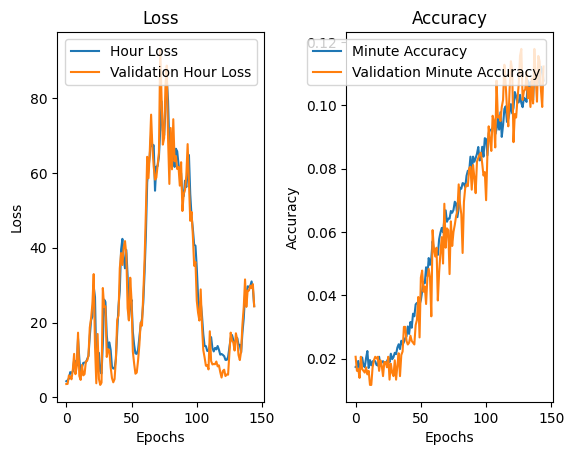

In [22]:
# model = keras.models.load_model("multihead_combination_model.keras")
plt.subplot(1, 2, 1)
plt.plot(history.history['output_hours_mae'], label='Hour Loss')
plt.plot(history.history['val_output_hours_mae'], label='Validation Hour Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['output_minutes_accuracy'], label='Minute Accuracy')
plt.plot(history.history['val_output_minutes_accuracy'], label='Validation Minute Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplots_adjust(wspace=0.4) 

plt.show()

hour accuracy

In [23]:
hour_pred, minute_pred = model.predict(X_test)

print(hour_pred)
print(tolerance_regression_rate(hour_pred, hour_test, 12, float(1/6)))

print(np.argmax(minute_pred, axis=1))
print(np.argmax(minute_test, axis=1))
print(np.sum(np.argmax(minute_pred, axis=1) == np.argmax(minute_test, axis=1))/len(minute_test))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[12.844953]
 [12.413728]
 [16.957315]
 ...
 [11.255969]
 [14.675002]
 [11.632356]]
0.1272222222222222
[51 54 44 ... 35 21 48]
[19 32 24 ... 27  5 38]
0.015555555555555555


minute accuracy

In [24]:
rate = tolerance_rate(minute_pred, minute_test, 60, 10)
print(rate)

0.35833333333333334


2. the hour prediction as a classification problem and the minute prediction as a regression problem.

In [33]:
X = X_original.astype('float32') / 255.0
y = y_original
y0 = y[:, 0].reshape(-1, 1)
minute_labels = y[:, 1].reshape(-1, 1)
hour_labels = keras.utils.to_categorical(y0, num_classes=12)

x_train, x_temp, hour_train, hour_test, minute_train, minute_test = train_test_split(X, hour_labels, minute_labels, test_size=0.2)
x_val, x_test, hour_val, hour_test, minute_val, minute_test = train_test_split(x_temp, hour_test, minute_test, test_size=0.5)

In [37]:
inputs = keras.Input(shape=(75, 75, 1), name="inputs")

conv1 = keras.layers.Conv2D(32, (3, 3), padding='SAME', strides=2, activation='relu', name="conv1")(inputs)
bn1 = keras.layers.BatchNormalization()(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(bn1)

conv2 = keras.layers.Conv2D(16, (3, 3), padding='SAME', strides=2, activation='relu', name="conv2")(pool1)
bn2 = keras.layers.BatchNormalization()(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(bn2)

flatten = keras.layers.Flatten(name="flatten")(pool2)

dense_hours = keras.layers.Dense(64, activation='relu', name="dense_hours", kernel_regularizer=keras.regularizers.l2(0.001))(flatten)
dropout_hours = keras.layers.Dropout(0.5, name="dropout_hours")(dense_hours)
output_hours = keras.layers.Dense(12, activation='softmax', name="output_hours")(dropout_hours)

conv3 = keras.layers.Conv2D(16, (3, 3), padding='SAME', activation='relu', name="conv3")(pool2)
bn3 = keras.layers.BatchNormalization()(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool3")(bn3)

conv4 = keras.layers.Conv2D(32, (3, 3), padding='SAME', activation='relu', name="conv4")(pool3)
bn4 = keras.layers.BatchNormalization()(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool4")(bn4)

flatten_minutes = keras.layers.Flatten(name="flatten_minutes")(pool4)

dense_minutes = keras.layers.Dense(32, activation='relu', name="dense_minutes", kernel_regularizer=keras.regularizers.l2(0.001))(flatten_minutes)
dropout_minutes = keras.layers.Dropout(0.5, name="dropout_minutes")(dense_minutes)
bn_dense1 = keras.layers.BatchNormalization()(dropout_minutes)

output_minutes = keras.layers.Dense(1, activation='linear', name="output_minutes")(bn_dense1)

In [38]:
model = keras.Model(inputs=inputs, outputs=[output_hours, output_minutes])
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss={'output_hours':get_custom_loss(12), 'output_minutes':get_custom_regression_loss(60, 10)}, loss_weights={"output_hours": 0.5, "output_minutes": 0.5}, optimizer=optimizer, metrics={'output_hours': ['accuracy'], 'output_minutes': ['mae']})

In [39]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("multihead_combination_model2.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(
    x_train, [hour_train, minute_train], epochs=300,
    validation_data=(x_val, [hour_val, minute_val]),
    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("multihead_combination_model2.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 8.3108 - output_hours_accuracy: 0.0902 - output_minutes_mae: 29.5235 - val_loss: 8.3380 - val_output_hours_accuracy: 0.0917 - val_output_minutes_mae: 28.2387
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.0740 - output_hours_accuracy: 0.0836 - output_minutes_mae: 29.6299 - val_loss: 8.3314 - val_output_hours_accuracy: 0.0911 - val_output_minutes_mae: 29.7711
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.0957 - output_hours_accuracy: 0.0888 - output_minutes_mae: 29.6956 - val_loss: 8.2405 - val_output_hours_accuracy: 0.0878 - val_output_minutes_mae: 29.1685
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.0820 - output_hours_accuracy: 0.0828 - output_minutes_mae: 29.4721 - val_loss: 8.1673 - val_output_hours_accuracy: 0.0883 - val_output_minutes_mae: 29.5452
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.9131 - output_hours_accuracy: 0.0888 - output_minutes_mae: 2

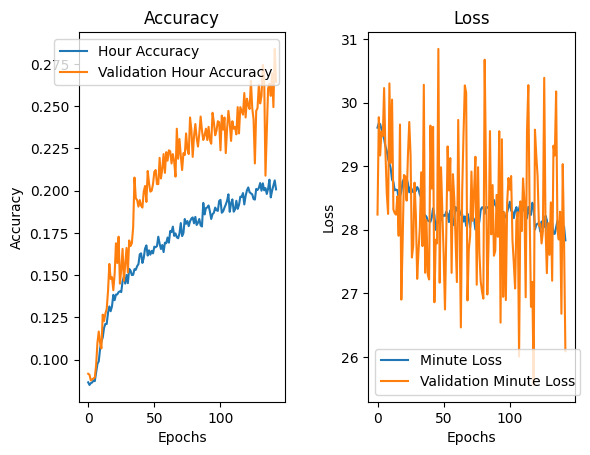

In [40]:
plt.subplot(1, 2, 1)
plt.plot(history.history['output_hours_accuracy'], label='Hour Accuracy')
plt.plot(history.history['val_output_hours_accuracy'], label='Validation Hour Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['output_minutes_mae'], label='Minute Loss')
plt.plot(history.history['val_output_minutes_mae'], label='Validation Minute Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplots_adjust(wspace=0.4) 

plt.show()

In [41]:
hour_pred, minute_pred = model.predict(x_test)
print(hour_test)

hour_pred = np.argmax(hour_pred, axis=1).reshape(-1, 1)
hour_test = np.argmax(hour_test, axis=1).reshape(-1, 1)

print(np.hstack((hour_pred, minute_pred)))
print(np.hstack((hour_test, minute_test)))
print(common_error(np.hstack((hour_pred, minute_pred)), np.hstack((hour_test, minute_test))))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[[  9.          -0.03230634]
 [  0.           1.2226944 ]
 [  3.         -19.2197113 ]
 ...
 [  7.          -0.03230634]
 [  4.          -0.03230634]
 [  3.          -6.03172064]]
[[ 6 53]
 [10  7]
 [ 2 23]
 ...
 [ 9 35]
 [ 6 55]
 [ 2 15]]
0.19555555555555557


# 4. Label Transform

To implement label transform, we use sine and cosine functions to represent the angles on the unit circle.
First, apply sine and cosine functions with total minutes.

In [43]:
X_train_full = X_original.astype('float32') / 255.0
y_train_full = y_original.astype(np.float64)
T = 720

for y in y_train_full:
    A = y[0]%12 * 60 + y[1]
    theta = 2 * np.pi * (A / T)
    y[0] = np.sin(theta)
    y[1] = np.cos(theta)
    
    
print(X_train_full.shape)
print(y_train_full.shape)

X_train, X_test_full, y_train, y_test_full = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=24)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=24)

(18000, 75, 75)
(18000, 2)


In [44]:
def custom_mse_loss(y_true, y_pred):
    sin_true, cos_true = y_true[:, 0], y_true[:, 1]
    sin_pred, cos_pred = y_pred[:, 0], y_pred[:, 1]
    
    sin_diff = sin_true - sin_pred
    cos_diff = cos_true - cos_pred
    
    loss = tf.reduce_mean(tf.square(sin_diff) + tf.square(cos_diff))
    return loss

In [45]:
def EP(input_shape):
    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.5))

    return model

model = EP((75, 75, 1))
model.add(keras.layers.Dense(2))
    
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=custom_mse_loss, metrics=[custom_mse_loss])    

# history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("transform_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("transform_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - custom_mse_loss: 1.0488 - loss: 1.2690 - val_custom_mse_loss: 0.9990 - val_loss: 1.1776
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.9763 - loss: 1.1460 - val_custom_mse_loss: 0.8899 - val_loss: 1.0394
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.8756 - loss: 1.0176 - val_custom_mse_loss: 0.7352 - val_loss: 0.8643
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.7730 - loss: 0.8943 - val_custom_mse_loss: 0.6130 - val_loss: 0.7245
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.6873 - loss: 0.7923 - val_custom_mse_loss: 0.5381 - val_loss: 0.6357
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.6045 - loss: 0.6963 - val_custom_mse_loss: 0.4901 - val_loss: 0.5763
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.5352 - loss: 0.6165 - val_custom_mse_loss: 0.3918 - val_loss: 0.46

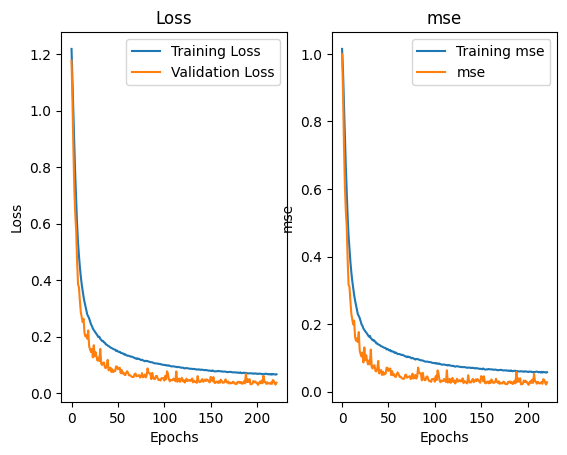

In [47]:
# model = keras.models.load_model("transform_model.keras")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_mse_loss'], label='Training mse')
plt.plot(history.history['val_custom_mse_loss'], label='mse')
plt.title('mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

In [48]:
def sin_cos_to_time(sin_val, cos_val, T=720):
    theta = np.arctan2(sin_val, cos_val)
    if theta < 0:
        theta += 2 * np.pi
    A = theta * T / (2 * np.pi)
    total_minutes = A
    hours = int((total_minutes // 60) % 12)
    minutes = int(total_minutes % 60)
    return hours, minutes

In [49]:
y_pred = model.predict(X_test)

pred_times = np.array([sin_cos_to_time(sin, cos) for sin, cos in y_pred])
print(pred_times[30:50])
true_times = np.array([sin_cos_to_time(sin, cos) for sin, cos in y_test])
print(true_times[30:50])

common_error(pred_times, true_times)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 2 42]
 [11  2]
 [ 1 27]
 [ 3  8]
 [10 11]
 [ 3 15]
 [ 6 26]
 [ 3 48]
 [ 6 31]
 [ 2 30]
 [10 54]
 [ 9 12]
 [ 7 37]
 [ 8 30]
 [ 4 34]
 [ 1  4]
 [ 1 32]
 [ 3 45]
 [ 7 22]
 [ 0 44]]
[[ 2 44]
 [10 42]
 [ 1 30]
 [ 3 26]
 [10 17]
 [ 3 11]
 [ 6 20]
 [ 3 49]
 [ 6 21]
 [ 2 52]
 [10 43]
 [ 9  0]
 [ 7 30]
 [ 8 19]
 [ 4 36]
 [ 0 56]
 [ 1 19]
 [ 3 51]
 [ 7 17]
 [ 1  1]]


0.6516666666666666

Secondly, set hour and minute apart, mapping each to an angle.

In [50]:
X_train_full = X_original.astype('float32') / 255.0
y_train_full = y_original.astype(np.float64)

y_t = np.zeros((y_train_full.shape[0], 4))

for i, y in enumerate(y_train_full):
    theta_hours = 2 * np.pi * (y[0] % 12) / 12
    y_t[i, 0] = np.sin(theta_hours)
    y_t[i, 1] = np.cos(theta_hours)
    
    # Convert minutes to sine and cosine
    theta_minutes = 2 * np.pi * y[1] / 60
    y_t[i, 2] = np.sin(theta_minutes)
    y_t[i, 3] = np.cos(theta_minutes)
    

X_train, X_test_full, y_train, y_test_full = train_test_split(X_train_full, y_t, test_size=0.2, random_state=24)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=24)


In [51]:
def custom_mse_loss(y_true, y_pred):
    sin_true, cos_true = y_true[:, 0:2], y_true[:, 2:4]
    sin_pred, cos_pred = y_pred[:, 0:2], y_pred[:, 2:4]
    
    sin_diff = sin_true - sin_pred
    cos_diff = cos_true - cos_pred
    
    loss = tf.reduce_mean(tf.square(sin_diff) + tf.square(cos_diff))
    return loss

In [52]:
model = EP((75, 75, 1))
model.add(keras.layers.Dense(4, activation='tanh'))
    
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=custom_mse_loss, metrics=[custom_mse_loss])    

In [53]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("transform_h_model.keras",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model.save("transform_h_model.keras")

Epoch 1/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - custom_mse_loss: 1.0250 - loss: 1.2297 - val_custom_mse_loss: 0.9937 - val_loss: 1.1287
Epoch 2/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.9534 - loss: 1.0771 - val_custom_mse_loss: 0.8156 - val_loss: 0.9167
Epoch 3/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.8285 - loss: 0.9214 - val_custom_mse_loss: 0.6816 - val_loss: 0.7625
Epoch 4/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.7304 - loss: 0.8046 - val_custom_mse_loss: 0.5845 - val_loss: 0.6519
Epoch 5/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.6537 - loss: 0.7152 - val_custom_mse_loss: 0.5073 - val_loss: 0.5649
Epoch 6/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.5895 - loss: 0.6425 - val_custom_mse_loss: 0.4653 - val_loss: 0.5161
Epoch 7/300
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - custom_mse_loss: 0.5252 - loss: 0.5735 - val_custom_mse_loss: 0.3970 - val_loss: 0.44

In [54]:
def sin_cos_to_time(sin_hour, cos_hour, sin_minute, cos_minute):
    theta_hour = np.arctan2(sin_hour, cos_hour)
    if theta_hour < 0:
        theta_hour += 2 * np.pi
    A = theta_hour * 12 / (2 * np.pi)
    hours = int(A % 12)
    
    theta_minute = np.arctan2(sin_minute, cos_minute)
    if theta_minute < 0:
        theta_minute += 2 * np.pi
    A = theta_minute * 60 / (2 * np.pi)
    minutes = int(A % 60)
    return hours, minutes

In [55]:
y_pred = model.predict(X_test)

# 转换回时间
pred_times = np.array([sin_cos_to_time(sin_hour, cos_hour, sin_minute, cos_minute) for sin_hour, cos_hour, sin_minute, cos_minute in y_pred])
print(pred_times)
true_times = np.array([sin_cos_to_time(sin_hour, cos_hour, sin_minute, cos_minute) for sin_hour, cos_hour, sin_minute, cos_minute in  y_test])
print(true_times)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 3 18]
 [ 7 43]
 [ 1 21]
 ...
 [ 7 55]
 [ 2 12]
 [ 2 11]]
[[ 4 19]
 [ 6 45]
 [ 1 21]
 ...
 [ 6 57]
 [ 3 10]
 [ 3  9]]


In [56]:
print(common_error(pred_times, true_times))

0.49944444444444447
